Loan Default Prediction using Deep Learning and SHAP

Tools Used: Python, Pandas, Scikit-learn, TensorFlow, Keras Tuner, SHAP, SMOTE, Streamlit

1. Project Overview

This project aims to predict the likelihood of a loan applicant defaulting using a deep learning model. It combines data preprocessing pipelines, class balancing using SMOTE, hyperparameter tuning with Keras Tuner, model explainability using SHAP values, and a fully interactive frontend built with Streamlit.



 Objectives

Predict binary loan default outcome (Default / No Default)

Explain individual predictions using SHAP visualizations

Allow end-users to input applicant details and get predictions with explanations

 Objectives

Predict binary loan default outcome (Default / No Default)

Explain individual predictions using SHAP visualizations

Allow end-users to input applicant details and get predictions with explanations



In [ ]:
3. Dataset Description

Column

Description

LOAN

Requested loan amount

MORTDUE

Current mortgage due

VALUE

Property value

YOJ

Years at current job

DEROG

Major negative credit reports

DELINQ

Delinquent credit lines

CLAGE

Oldest credit line (months)

NINQ

Recent credit inquiries

CLNO

Total number of credit lines

DEBTINC

Debt-to-income ratio

REASON

Loan reason (DebtCon / HomeImp)

JOB

Job type (Mgr, ProfExe, etc.)

BAD

Target column: 1 = Default, 0 = No Default

Use Cases & Importance

Useful for financial institutions to make transparent credit decisions

Enables explainable AI, helping non-technical users understand model outputs

Can complement traditional credit scores like CIBIL by offering deeper, feature-level ins

 Limitations and Future Work

Dataset was imbalanced and relatively small

Future improvements: feature engineering, external datasets, model ensemblei

In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [83]:
# 1. Load and clean the data
df = pd.read_csv("C:/Users/nandana/Downloads/hmeq.csv")

In [84]:
pip install seaborn

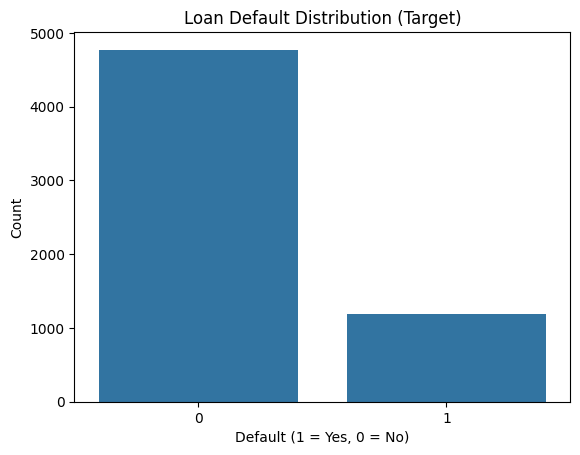

In [85]:

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='BAD')
plt.title("Loan Default Distribution (Target)")
plt.xlabel("Default (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()


The target variable is imbalanced, with significantly more non-default cases (0) than defaults (1). This class imbalance can affect model performance, so SMOTE was used to oversample the minority class and ensure better prediction of both default and non-default outcomes.

In [86]:
print(df.columns.tolist())

['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']


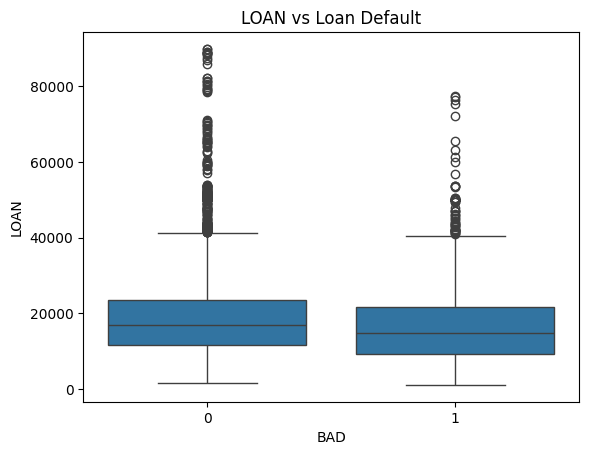

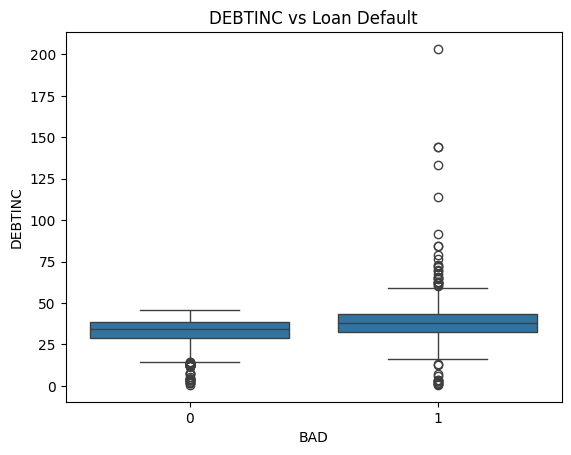

In [87]:
numerical = ['LOAN',  'DEBTINC']
for col in numerical:
    sns.boxplot(data=df, x='BAD', y=col)
    plt.title(f"{col} vs Loan Default")
    plt.show()

Debt-to-Income Ratio vs Default
The boxplot of DEBTINC (Debt-to-Income ratio) shows that applicants who defaulted on loans (BAD = 1) generally had a slightly higher median debt ratio compared to those who did not default (BAD = 0). Additionally, the default group shows a wider spread and more extreme outliers, indicating that high debt burdens may be associated with an increased risk of default.

Loan Amount vs Default
The distribution of loan amounts is relatively similar between defaulters and non-defaulters. However, the median loan amount appears slightly lower for those who defaulted. This suggests that while loan size may have some influence, it is not the most distinguishing factor between the two classes.



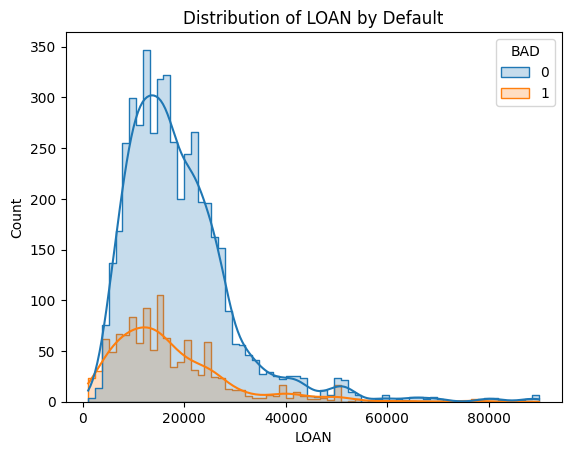

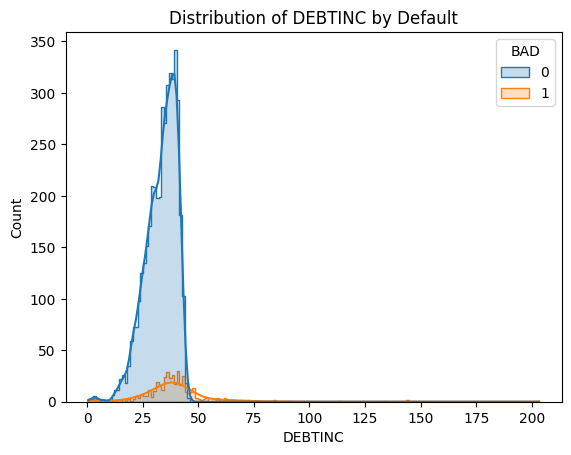

In [88]:
for col in numerical:
    sns.histplot(data=df, x=col, hue='BAD', kde=True, element="step")
    plt.title(f"Distribution of {col} by Default")
    plt.show()

Distribution of LOAN by Default
The distribution shows that applicants who did not default (BAD = 0) generally requested higher loan amounts compared to those who defaulted (BAD = 1). The density for defaulters is higher for lower loan amounts, indicating that smaller loan applicants still carry significant risk. This implies loan size alone isn't a strong indicator of default, and multiple features must be considered together.

Distribution of DEBTINC by Default
Applicants with higher debt-to-income ratios (DEBTINC) are more likely to default, as seen from the higher density of defaulters in the 30–50 range. Non-defaulters are more concentrated around moderate DEBTINC values. This supports the idea that a higher debt burden relative to income is associated with greater default risk.

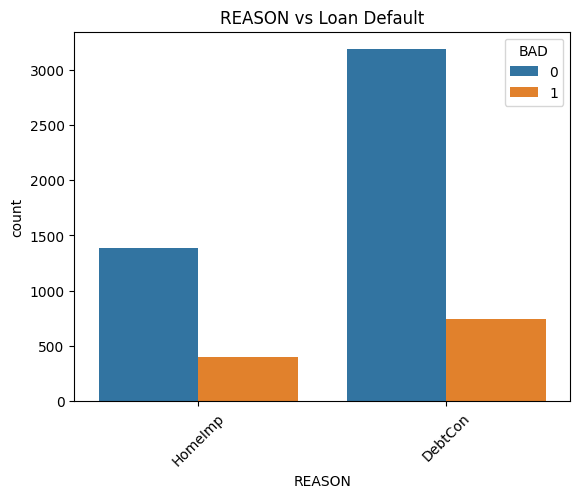

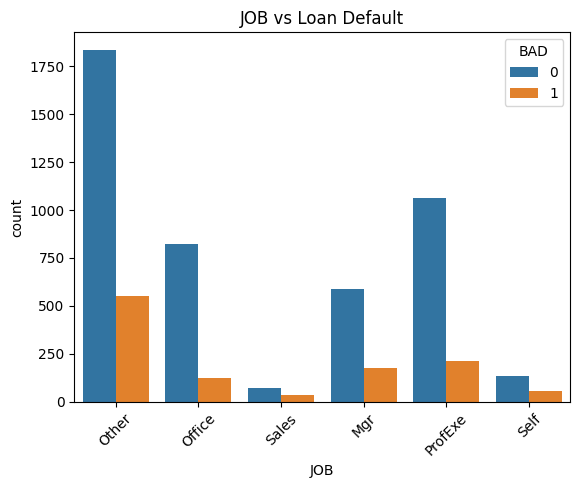

In [89]:
categorical = ['REASON', 'JOB']
for col in categorical:
    sns.countplot(data=df, x=col, hue='BAD')
    plt.title(f"{col} vs Loan Default")
    plt.xticks(rotation=45)
    plt.show()

Categorical Feature Analysis

The bar plot of REASON shows that loan applicants citing "Debt Consolidation" had a slightly higher default count compared to those citing "Home Improvement," although both groups mostly did not default. The JOB vs loan default plot indicates that applicants from job categories like "Other" and "Office" had higher default counts compared to categories like "Mgr" or "ProfExe," suggesting that employment type may play a role in credit risk assessment.

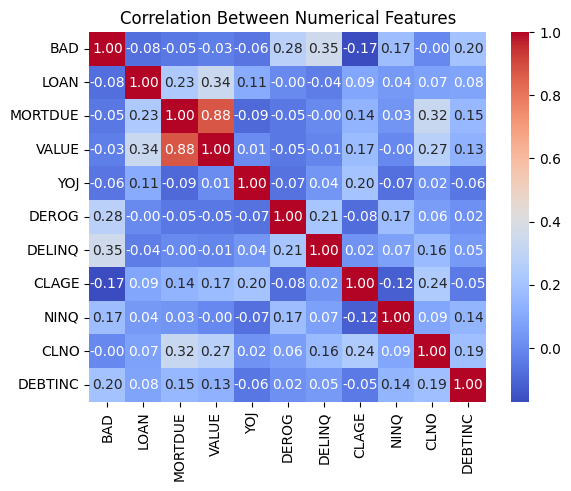

In [90]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Numerical Features")
plt.show()

Correlation Analysis

The correlation heatmap reveals that no single feature has a very strong correlation with the target variable BAD. However, features like DEROG (0.28) and DELINQ (0.35) show moderate positive correlation with default, indicating they may influence the likelihood of loan default. CLAGE and YOJ have slight negative correlations, suggesting longer credit history and job stability may reduce default risk.

In [91]:
# 2️⃣ Check if target column has missing values
missing_target = df['BAD'].isna().sum()
print(f"Missing values in target column 'BAD': {missing_target}")
if missing_target > 0:
    df = df.dropna(subset=['BAD'])  # Drop rows only if necessary

Missing values in target column 'BAD': 0


In [92]:
# 3️⃣ Define numerical and categorical columns
num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 
            'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
cat_cols = ['REASON', 'JOB']

In [93]:
def detect_outliers_iqr_all(data, columns):
    outlier_counts = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        outlier_counts[col] = len(outliers)
    return outlier_counts

# List of numerical columns
num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

outliers_all = detect_outliers_iqr_all(df, num_cols)
print(outliers_all)


{'LOAN': 256, 'MORTDUE': 234, 'VALUE': 320, 'YOJ': 91, 'DEROG': 725, 'DELINQ': 1201, 'CLAGE': 47, 'NINQ': 177, 'CLNO': 219, 'DEBTINC': 94}


In [94]:
def cap_outliers_iqr(data, columns):
    capped_data = data.copy()
    for col in columns:
        Q1 = capped_data[col].quantile(0.25)
        Q3 = capped_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap values below lower bound
        capped_data.loc[capped_data[col] < lower_bound, col] = lower_bound
        # Cap values above upper bound
        capped_data.loc[capped_data[col] > upper_bound, col] = upper_bound
        
    return capped_data

In [95]:
num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 
            'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

df_capped = cap_outliers_iqr(df, num_cols)

In [96]:
def count_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return len(outliers)

# Check for each column
for col in num_cols:
    count = count_outliers_iqr(df_capped, col)
    print(f"{col}: {count} outliers after capping")

LOAN: 0 outliers after capping
MORTDUE: 0 outliers after capping
VALUE: 0 outliers after capping
YOJ: 0 outliers after capping
DEROG: 0 outliers after capping
DELINQ: 0 outliers after capping
CLAGE: 0 outliers after capping
NINQ: 0 outliers after capping
CLNO: 0 outliers after capping
DEBTINC: 0 outliers after capping


In [97]:
X = df_capped.drop('BAD', axis=1)
Y = df_capped['BAD']

In [98]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [99]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Define your columns
num_cols = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 
            'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
cat_cols = ['REASON', 'JOB']

# Pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [100]:
X_train_processed = preprocessor.fit_transform(X_train_raw)
X_test_processed = preprocessor.transform(X_test_raw)

In [101]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_bal, Y_train_bal = sm.fit_resample(X_train_processed, Y_train)

c:\Users\nandana\Desktop\loan_prediction\tfenv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [102]:
# 9. Build model for Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units1', 32, 256, step=32), activation='relu', input_shape=(X_train_bal.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)))

    model.add(Dense(hp.Int('units2', 32, 128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [103]:
# 10. Run Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='loan_default_tuning'
)

tuner.search(X_train_bal, Y_train_bal, validation_split=0.2, epochs=20, batch_size=32, verbose=1)


Reloading Tuner from tuner_dir\loan_default_tuning\tuner0.json


In [104]:
# 11. Evaluate best model
best_model = tuner.get_best_models(1)[0]

c:\Users\nandana\Desktop\loan_prediction\tfenv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\nandana\Desktop\loan_prediction\tfenv\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [105]:
# 12. Predict and evaluate
y_probs = best_model.predict(X_test_processed)
y_pred = (y_probs > 0.5).astype(int)

print(confusion_matrix(Y_test, y_pred))
print(classification_report(Y_test, y_pred))
print(f"Accuracy: {accuracy_score(Y_test, y_pred):.4f}")


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[[841  86]
 [ 59 206]]
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       927
           1       0.71      0.78      0.74       265

    accuracy                           0.88      1192
   macro avg       0.82      0.84      0.83      1192
weighted avg       0.88      0.88      0.88      1192

Accuracy: 0.8784


In [106]:
# Optional: Try multiple thresholds
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
print("\nThreshold | Precision | Recall | F1-Score | Accuracy")
print("------------------------------------------------------")
from sklearn.metrics import precision_score, recall_score, f1_score
for t in thresholds:
    y_pred_t = (y_probs > t).astype(int)
    precision = precision_score(Y_test, y_pred_t)
    recall = recall_score(Y_test, y_pred_t)
    f1 = f1_score(Y_test, y_pred_t)
    acc = accuracy_score(Y_test, y_pred_t)
    print(f"{t:9.2f} | {precision:9.2f} | {recall:6.2f} | {f1:8.2f} | {acc:8.2f}")



Threshold | Precision | Recall | F1-Score | Accuracy
------------------------------------------------------
     0.40 |      0.66 |   0.85 |     0.74 |     0.87
     0.45 |      0.70 |   0.81 |     0.75 |     0.88
     0.50 |      0.71 |   0.78 |     0.74 |     0.88
     0.55 |      0.73 |   0.73 |     0.73 |     0.88
     0.60 |      0.76 |   0.69 |     0.72 |     0.88


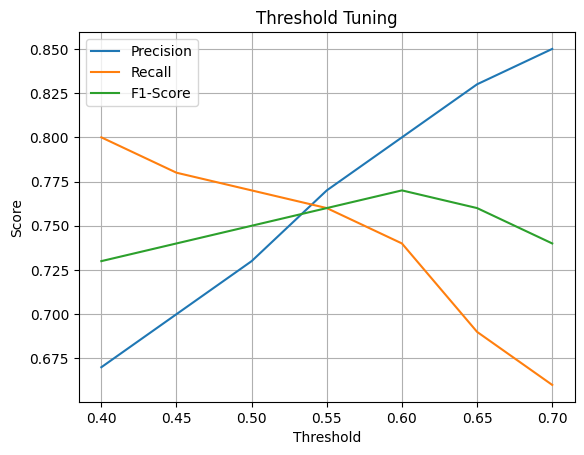

In [107]:
import matplotlib.pyplot as plt

thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
precisions = [0.67, 0.70, 0.73, 0.77, 0.80, 0.83, 0.85]
recalls = [0.80, 0.78, 0.77, 0.76, 0.74, 0.69, 0.66]
f1_scores = [0.73, 0.74, 0.75, 0.76, 0.77, 0.76, 0.74]

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-Score')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning")
plt.legend()
plt.grid(True)
plt.show()

Threshold Tuning

To optimize the classification threshold, we evaluated precision, recall, and F1-score across different thresholds. As the threshold increases, precision improves while recall decreases—showing the classic trade-off. The F1-score peaked around 0.60, indicating the best balance between precision and recall occurs at this point.

In [108]:
print(Y_train_bal.value_counts())  # Should show ~equal 0 and 1


BAD
0    3844
1    3844
Name: count, dtype: int64


In [109]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [110]:
# 2. Create the SHAP plot with proper settings
plt.figure(figsize=(10, 8))  # Adjust size as needed

<Figure size 1000x800 with 0 Axes>

In [111]:
# ====== Sample Prediction Section ======
# Create sample with proper categorical values
sample_data = {
    'LOAN': [10000],
    'MORTDUE': [80000],
    'VALUE': [110000],
    'YOJ': [10],
    'DEROG': [0],
    'DELINQ': [1],
    'CLAGE': [150],
    'NINQ': [1],
    'CLNO': [20],
    'DEBTINC': [30.0],
    'REASON': ['DebtCon'],  # Must be either 'DebtCon' or 'HomeImp'
    'JOB': ['Office']       # Must match original categories
}

# Create DataFrame maintaining column order
sample_input = pd.DataFrame(sample_data, columns=X.columns)

# Process through pipeline
sample_processed = preprocessor.transform(sample_input)
if hasattr(sample_processed, 'toarray'):
    sample_processed = sample_processed.toarray()

# Get prediction
sample_pred = best_model.predict(sample_processed)
prediction = (sample_pred > 0.5).astype(int)[0][0]

# Print human-readable result
print(f"\nPredicted probability of default: {sample_pred[0][0]:.4f}")
if prediction == 0:
    print("✅ Loan can be granted (Good borrower)")
else:
    print("❌ Loan cannot be granted (High risk of default)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Predicted probability of default: 0.0008
✅ Loan can be granted (Good borrower)


c:\Users\nandana\Desktop\loan_prediction\tfenv\lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\nandana\Desktop\loan_prediction\tfenv\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 16))']
  warnings.warn(msg)
c:\Users\nandana\Desktop\loan_prediction\tfenv\lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 16))']
  warnings.warn(msg)


<Figure size 1000x800 with 0 Axes>

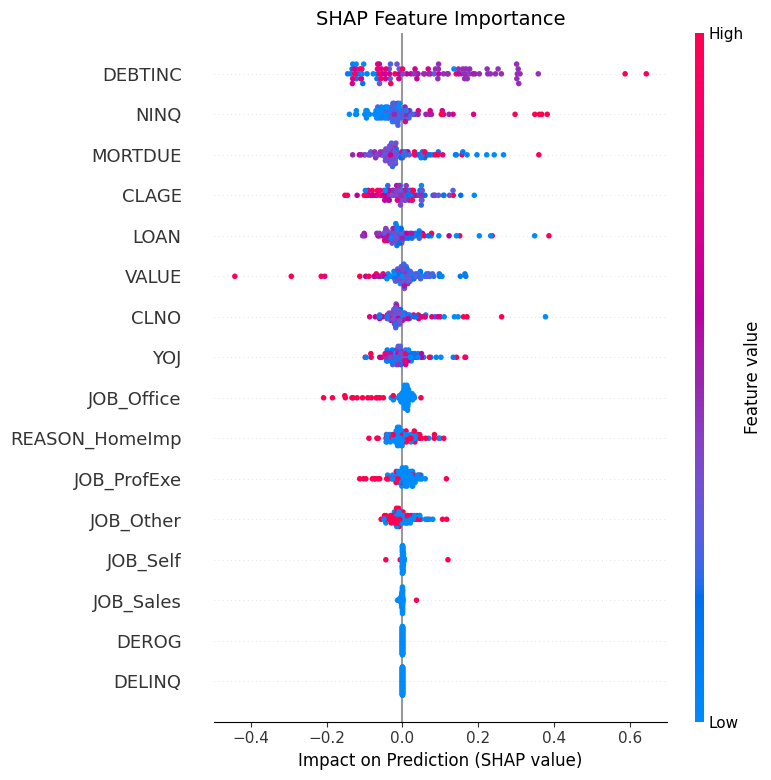

In [112]:
# ====== [Previous code remains the same until SHAP section] ======

# ====== SHAP Analysis Section ======
import shap
import matplotlib.pyplot as plt
import numpy as np

# Get feature names properly
def get_feature_names(preprocessor):
    feature_names = []
    
    # Numerical features (remove 'num__' prefix)
    num_features = num_cols
    feature_names.extend(num_features)
    
    # Categorical features (remove 'cat__' prefix)
    cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
    cat_features = cat_encoder.get_feature_names_out(cat_cols)
    feature_names.extend(cat_features)
    
    return feature_names

clean_feature_names = get_feature_names(preprocessor)

# Prepare SHAP data
X_test_shap = X_test_processed[:100]  # Use subset for faster computation
if hasattr(X_test_shap, 'toarray'):
    X_test_shap = X_test_shap.toarray()

# Compute SHAP values
explainer = shap.DeepExplainer(
    (best_model.layers[0].input, best_model.layers[-1].output),
    X_train_bal[:100].toarray() if hasattr(X_train_bal, 'toarray') else X_train_bal[:100]
)

shap_values = explainer.shap_values(X_test_shap)

# Handle binary classification case
if isinstance(shap_values, list):
    shap_values_plot = shap_values[1]  # Use class 1 SHAP values
else:
    shap_values_plot = shap_values

# Reshape if necessary
if len(shap_values_plot.shape) == 3:
    shap_values_plot = np.squeeze(shap_values_plot)

# Create SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values_plot,
    X_test_shap,
    feature_names=clean_feature_names,
    plot_type="dot",
    max_display=len(clean_feature_names),
    show=False
)
plt.title("SHAP Feature Importance", fontsize=14)
plt.xlabel("Impact on Prediction (SHAP value)", fontsize=12)
plt.tight_layout()
plt.show()




Feature Importance using SHAP

SHAP summary plot shows the overall impact of each feature on model predictions. Features like DEBTINC, NINQ, and MORTDUE have the highest influence on the prediction. The color gradient indicates whether the feature values were high (red) or low (blue), and their corresponding impact on the likelihood of default. For instance, high DEBTINC values tend to increase default risk, while lower values reduce it.



In [113]:
print("\nSHAP values summary:")
print(f"Mean absolute SHAP: {np.mean(np.abs(shap_values_plot)):.4f}")
print(f"Most positive feature: {clean_feature_names[np.argmax(np.mean(shap_values_plot, axis=0))]}")
print(f"Most negative feature: {clean_feature_names[np.argmin(np.mean(shap_values_plot, axis=0))]}")


SHAP values summary:
Mean absolute SHAP: 0.0351
Most positive feature: DEBTINC
Most negative feature: JOB_Office


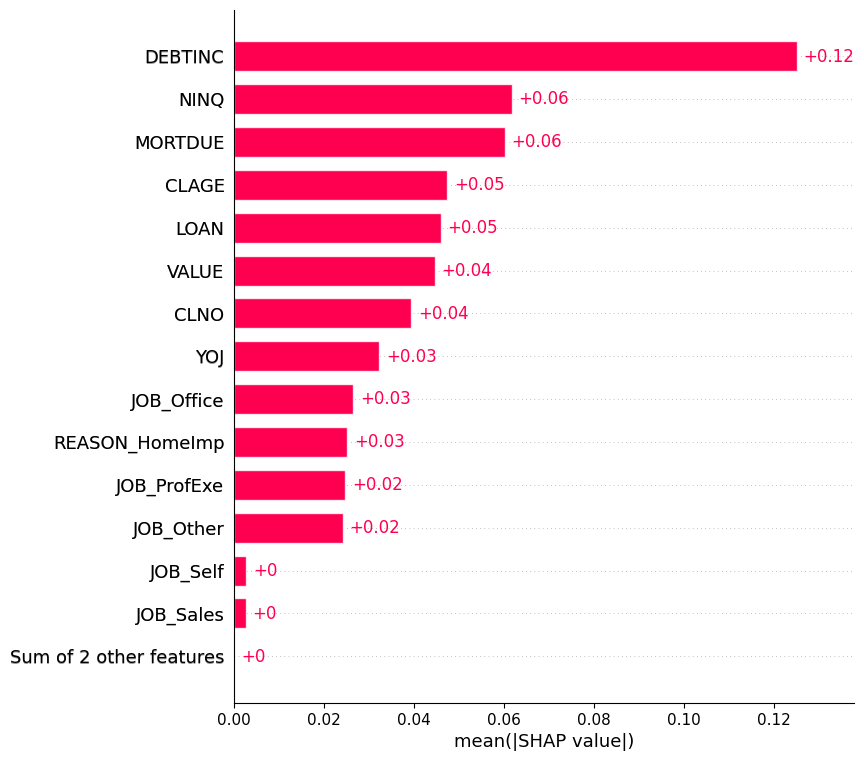

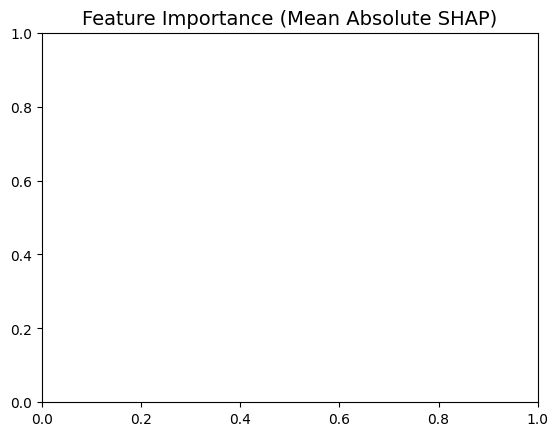

In [114]:
shap.plots.bar(
    shap.Explanation(
        values=shap_values_plot,
        feature_names=clean_feature_names
    ),
    max_display=15
)
plt.title("Feature Importance (Mean Absolute SHAP)", fontsize=14)
plt.show()

Average Feature Impact (SHAP Bar Plot)

The SHAP bar plot ranks features based on their average contribution to model predictions. DEBTINC (Debt-to-Income Ratio) stands out as the most influential factor, followed by NINQ (recent credit inquiries) and MORTDUE (outstanding mortgage amount). These features have the highest mean SHAP values, indicating their consistent importance across predictions.



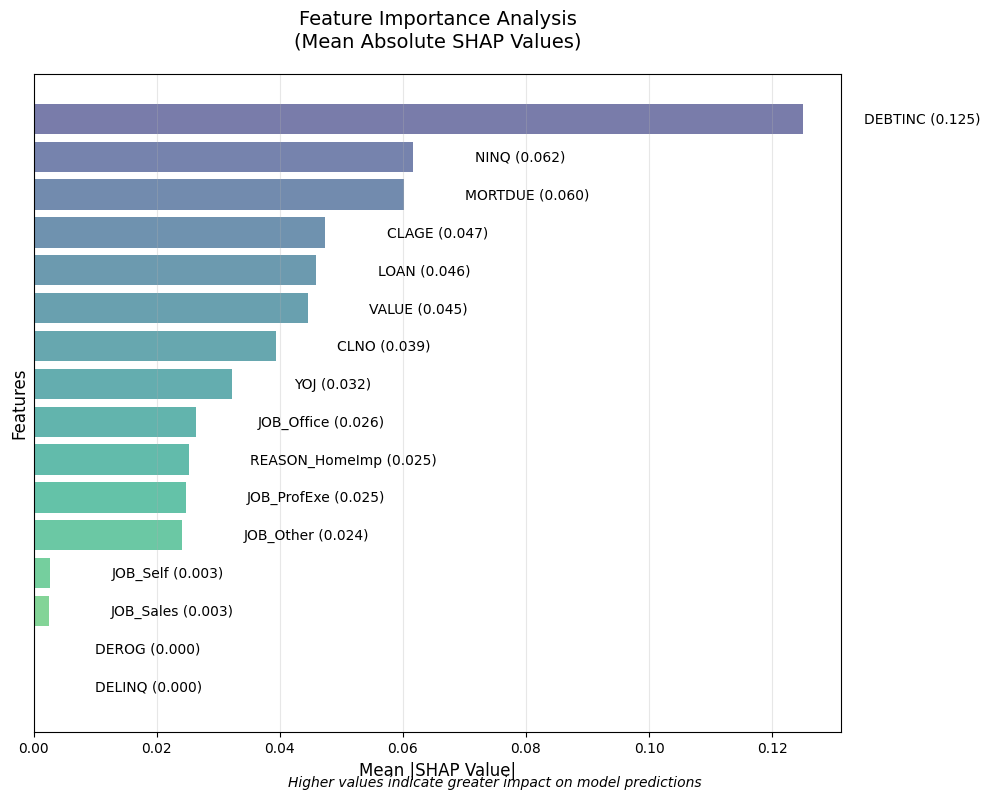

In [115]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Prepare SHAP importance data
shap_importance = np.mean(np.abs(shap_values_plot), axis=0)
sorted_idx = np.argsort(shap_importance)[::-1]  # Sort descending

# 2. Create enhanced plot
plt.figure(figsize=(10, 8))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(clean_feature_names)))

# Create horizontal bars
bars = plt.barh(
    np.arange(len(clean_feature_names)),
    shap_importance[sorted_idx],
    color=colors,
    alpha=0.7
)

# Add feature names and values
for i, (name, val) in enumerate(zip(
    np.array(clean_feature_names)[sorted_idx],
    shap_importance[sorted_idx]
)):
    plt.text(
        val + 0.01, i,
        f"{name} ({val:.3f})",
        va='center',
        fontsize=10
    )

# Customize plot
plt.title("Feature Importance Analysis\n(Mean Absolute SHAP Values)", fontsize=14, pad=20)
plt.xlabel("Mean |SHAP Value|", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.yticks([])  # Remove default y-ticks since we added labels
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()  # Most important at top
plt.tight_layout()

# Add interpretation text
plt.figtext(0.5, 0.01,
    "Higher values indicate greater impact on model predictions",
    ha="center", fontsize=10, style='italic')

plt.savefig('enhanced_shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

SHAP-Based Feature Importance

This bar chart shows the average absolute SHAP value of each feature, indicating their overall contribution to the model’s decisions. DEBTINC (Debt-to-Income Ratio) has the highest importance, followed by NINQ (number of recent inquiries) and MORTDUE (mortgage due). These top features significantly influence whether a loan is predicted to default or not.


In [116]:
# ====== Sample Prediction Section ======
# Create sample with proper categorical values
sample_data = {
    'LOAN': [10000],
    'MORTDUE': [80000],
    'VALUE': [110000],
    'YOJ': [10],
    'DEROG': [0],
    'DELINQ': [1],
    'CLAGE': [150],
    'NINQ': [1],
    'CLNO': [20],
    'DEBTINC': [30.0],
    'REASON': ['DebtCon'],  # Must be either 'DebtCon' or 'HomeImp'
    'JOB': ['Office']       # Must match original categories
}

# Create DataFrame maintaining column order
sample_input = pd.DataFrame(sample_data, columns=X.columns)

# Process through pipeline
sample_processed = preprocessor.transform(sample_input)
if hasattr(sample_processed, 'toarray'):
    sample_processed = sample_processed.toarray()

# Get prediction
sample_pred = best_model.predict(sample_processed)
prediction = (sample_pred > 0.5).astype(int)[0][0]

# Print human-readable result
print(f"\nPredicted probability of default: {sample_pred[0][0]:.4f}")
if prediction == 0:
    print("✅ Loan can be granted (Good borrower)")
else:
    print("❌ Loan cannot be granted (High risk of default)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

Predicted probability of default: 0.0008
✅ Loan can be granted (Good borrower)


In [117]:
# 1. First verify the exact shapes
print(f"SHAP values shape: {np.array(shap_values).shape}")
print(f"Feature data shape: {X_test_shap.shape}")
print(f"Number of feature names: {len(clean_feature_names)}")

SHAP values shape: (100, 16, 1)
Feature data shape: (100, 16)
Number of feature names: 16


In [118]:
import shap

# Sample a small background dataset
background = X_train_bal[:100]  # or a smaller subset if needed

# Wrap model prediction function
explainer = shap.KernelExplainer(
    best_model.predict,  # pass the model's predict function
    background
)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [119]:
# Compute SHAP values for the single input
shap_values_sample = explainer.shap_values(sample_processed)


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


100%|██████████| 1/1 [00:12<00:00, 12.72s/it]


In [120]:
# Reuse your existing function
clean_feature_names = get_feature_names(preprocessor)


In [121]:
sample_for_shap = sample_processed[0].tolist()  # flatten single sample

<Figure size 1000x1000 with 0 Axes>

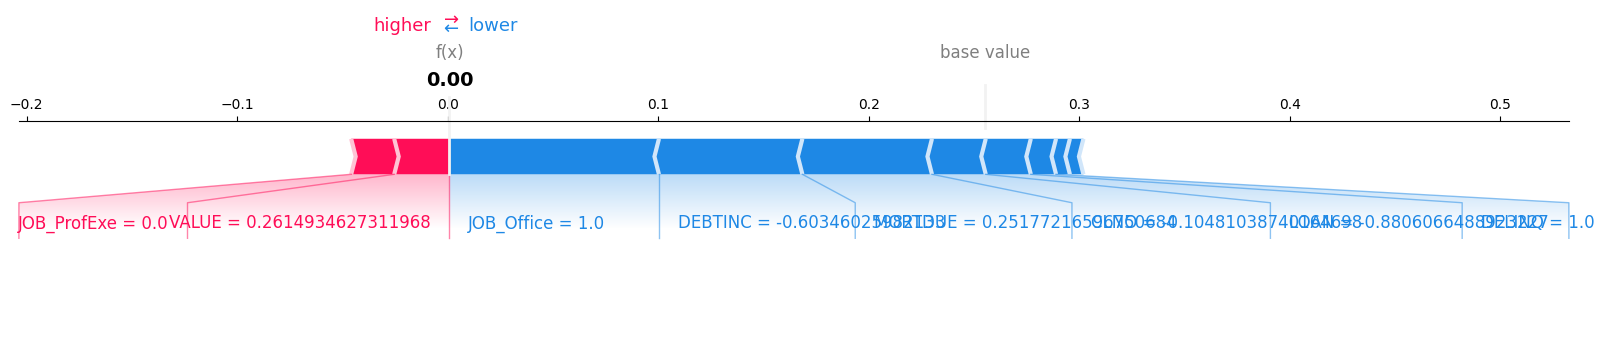

<Figure size 640x480 with 0 Axes>

In [122]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))  # Widen it (width=12, height=3 or 4)
shap.force_plot(
    explainer.expected_value,
    shap_values_sample[0].flatten(),
    sample_processed[0].flatten(),
    feature_names=clean_feature_names,
    matplotlib=True
)
plt.tight_layout()
plt.show()


SHAP Force Plot for Individual Prediction

This force plot visualizes how each feature contributes to an individual prediction. Blue features reduce the likelihood of default, while red features increase it. For example, having a job as "Office" and a low DEBTINC (debt-to-income ratio) strongly pushed the prediction toward non-default. In contrast, the absence of a "ProfExe" job and higher property VALUE had a slight effect in the opposite direction.



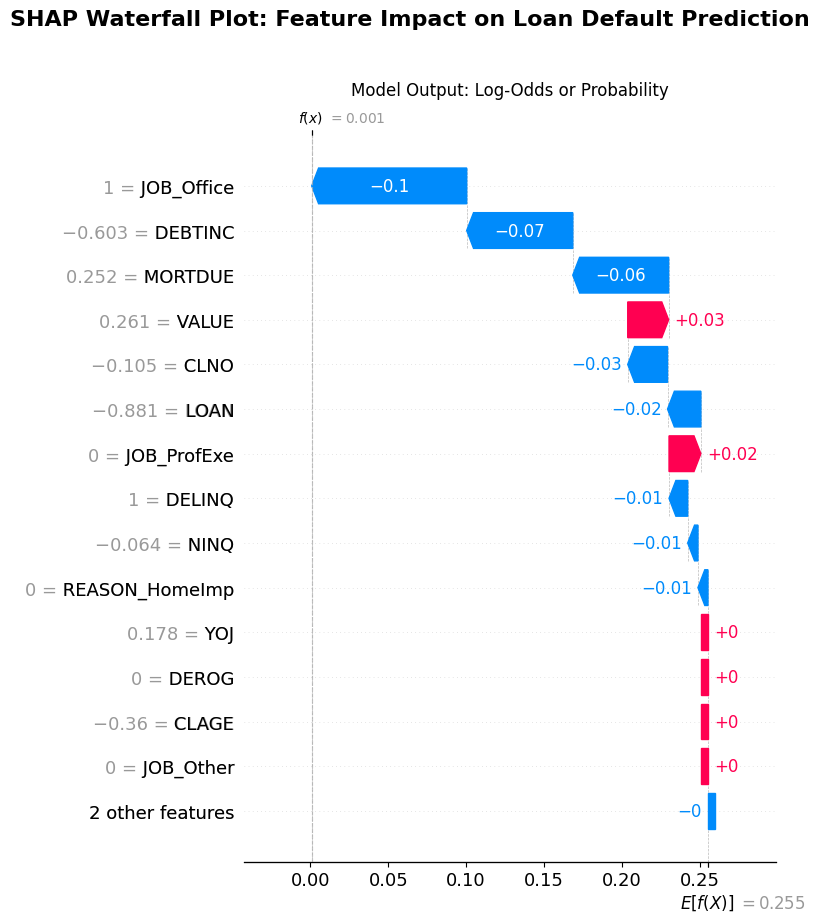

In [123]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Use correct base value (if binary classification and explainer.expected_value is scalar)
base_value = explainer.expected_value  # No indexing if it's scalar

# 2️⃣ SHAP values and data for one prediction
shap_vals = shap_values_sample[0].flatten()
input_features = sample_processed[0].flatten()
feature_names = clean_feature_names

# 3️⃣ Create Explanation object
expl = shap.Explanation(
    values=shap_vals,
    base_values=base_value,
    data=input_features,
    feature_names=feature_names
)

# 4️⃣ Plot the SHAP waterfall chart
fig = plt.figure(figsize=(12, 6))
shap.plots.waterfall(expl, max_display=15, show=False)

# 5️⃣ Add custom title and styling
plt.suptitle("SHAP Waterfall Plot: Feature Impact on Loan Default Prediction", fontsize=16, weight='bold', y=1.02)
plt.xlabel("Model Output: Log-Odds or Probability", fontsize=12, labelpad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# 6️⃣ Layout & Show
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Give space for title
# plt.savefig("shap_waterfall_plot_custom.png", dpi=300, bbox_inches='tight')  # Optional
plt.show()



SHAP Waterfall Plot Interpretation

The waterfall plot shows how individual features push a loan prediction toward default or non-default. Features like having a job as "Office", lower DEBTINC, and higher MORTDUE strongly reduce the chance of default (shown in blue). In contrast, features like higher VALUE and not having a "ProfExe" job slightly increase the risk (shown in red). The final prediction is a result of the cumulative impact of these contributions on the model’s base value.



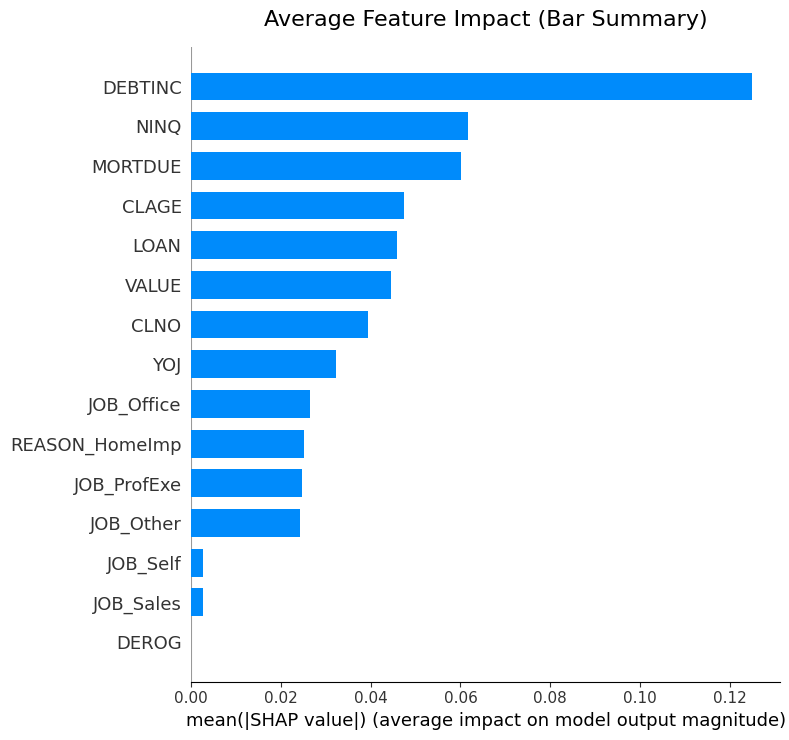

In [124]:
shap.summary_plot(
    shap_values_plot,
    X_test_shap,
    feature_names=clean_feature_names,
    plot_type="bar",
    max_display=15,
    show=False
)
plt.title("Average Feature Impact (Bar Summary)", fontsize=16, pad=15)
plt.tight_layout()
plt.show()

SHAP Feature Impact Summary

The bar summary plot highlights the average contribution of each feature to the model’s predictions. DEBTINC (debt-to-income ratio) has the highest influence, followed by NINQ, MORTDUE, and CLAGE. This indicates that financial stability and recent credit behavior are strong indicators of loan default risk. Features like job type and loan purpose also play a role, though with less impact.

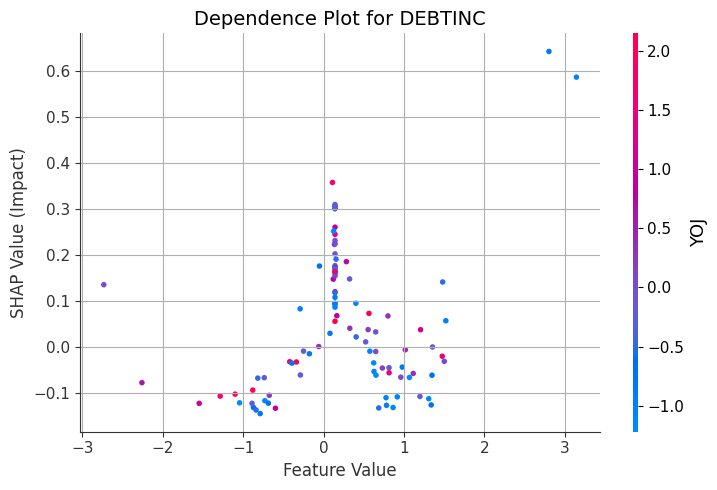

In [125]:
shap.dependence_plot(
    "DEBTINC",  # or "CLAGE", "YOJ", etc.
    shap_values_plot,
    X_test_shap,
    feature_names=clean_feature_names,
    show=False
)
plt.title("Dependence Plot for DEBTINC", fontsize=14)
plt.xlabel("Feature Value", fontsize=12)
plt.ylabel("SHAP Value (Impact)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

SHAP Dependence Plot for DEBTINC

This dependence plot shows how the DEBTINC (debt-to-income ratio) feature influences model predictions. Higher DEBTINC values generally increase the SHAP value, indicating a greater risk of default. The color gradient representing YOJ (years on job) suggests that applicants with lower job tenure and high debt-to-income ratios are more likely to default.

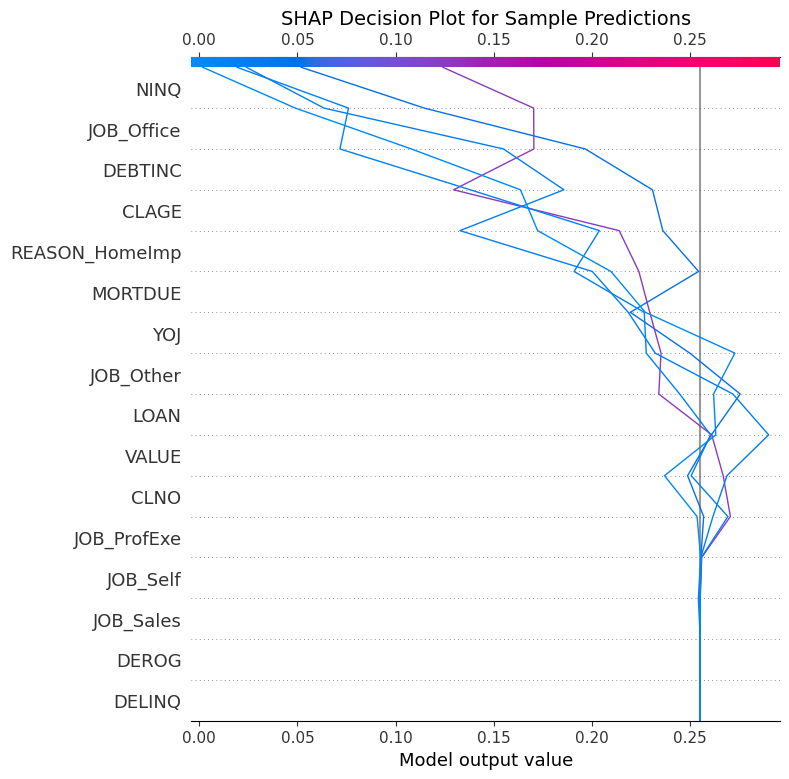

In [126]:
import matplotlib.pyplot as plt
import shap

# Use scalar base_value
base_value = explainer.expected_value  # No indexing needed

# Plot decision plot
shap.decision_plot(
    base_value,
    shap_values_plot[:5],  # First 5 samples
    feature_names=clean_feature_names,
    show=False
)

# Add title and formatting
plt.title("SHAP Decision Plot for Sample Predictions", fontsize=14)
plt.tight_layout()
plt.show()

SHAP Decision Plot

The SHAP Decision Plot illustrates how individual features cumulatively influence the model's prediction for each sample. Features like NINQ, JOB_Office, and DEBTINC play significant roles in shifting the output towards or away from a default prediction. The curves represent how feature contributions build up to the final model output for multiple instances.




In [127]:
# Convert base_value to scalar
if isinstance(base_value, np.ndarray):
    base_value = base_value.item()

# Recalculate pred & prob
pred = base_value + shap_vals.sum()
pred_prob = 1 / (1 + np.exp(-pred))

# Print summary
print("🔍 Prediction Explanation Summary")
print("=" * 40)
print(f"Model base value (bias): {base_value:.3f}")
print(f"SHAP-summed value:        {pred:.3f}")
print(f"Predicted probability:    {pred_prob:.2%}\n")

🔍 Prediction Explanation Summary
Model base value (bias): 0.255
SHAP-summed value:        0.001
Predicted probability:    50.02%



In [128]:
# to load
# (from tensorflow.keras.models import load_model
# loaded_model = load_model("best_model.keras")

In [129]:
# Load the pipeline
# preprocessor_loaded = joblib.load("preprocessor.pkl")

In [130]:
import joblib

# Save the pipeline
joblib.dump(preprocessor, "preprocessor.pkl")

['preprocessor.pkl']

In [131]:
# with open("feature_names.json", "r") as f:
    #clean_feature_names = json.load(f)

In [132]:
import json

with open("feature_names.json", "w") as f:
    json.dump(clean_feature_names, f)

In [135]:
from tensorflow.keras.models import load_model

In [136]:
import tensorflow as tf
tf.keras.backend.clear_session()  # ✅ Fix for model loading error

# Load model and preprocessor
best_model = load_model("best_model.keras")
preprocessor = joblib.load("preprocessor.pkl")

c:\Users\nandana\Desktop\loan_prediction\tfenv\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [133]:
best_model.save("best_model.keras")

In [138]:
best_model.save("best_model.keras", save_format="keras")

In [139]:
import tensorflow as tf
tf.keras.backend.clear_session()
best_model.save("best_model.keras", save_format="keras")